# Summary plot

__last update__: 24/01/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
%matplotlib inline
plt.rc('image', interpolation='none', origin='lower')

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
SAVE_FIGURES = True
figure_dir = 'figures'

# WARNING: make sure to get the correct fits file below 
data_no_pert = fits.getdata(os.path.join('molet', 'molet_sim_no_pert', 'output', 'OBS_gaussian03.fits'), header=False)

In [3]:
# Define some custom colormaps
#try:
#    import palettable
#except ImportError:
#    cmap_base = plt.get_cmap('cubehelix')
#else:
#    cmap_base = palettable.cubehelix.Cubehelix.make(name='flux_colormap',
#                                                    start=0.5,
#                                                    rotation=-1,
#                                                    gamma=0.8,
#                                                    sat=0.8,
#                                                    n=256).mpl_colormap
cmap_base = copy.copy(plt.get_cmap('magma'))
cmap_base.set_under('black')
cmap_base.set_over('white')
cmap_flux = copy.copy(cmap_base)
cmap_flux.set_bad(color='black')
cmap_flux_alt = copy.copy(cmap_base)
cmap_flux_alt.set_bad(color='#222222')  # to emphasize non-positive pixels in log scale
cmap_res = plt.get_cmap('RdBu_r')
cmap_corr = copy.copy(plt.get_cmap('Spectral_r'))
cmap_corr_cut = ListedColormap(cmap_corr(np.linspace(0.5, 1, 128)))
cmap_default = plt.get_cmap('viridis')
cmap_default_cut = ListedColormap(cmap_default(np.linspace(0.5, 1, 128)))
cmap_deriv1 = plt.get_cmap('cividis')
cmap_deriv2 = plt.get_cmap('inferno')

In [4]:
# types of potential perturbations we consider
perturb_types = ['dark halo', 'discyness', 'GRF']

# for each case, load the saved data from the modeling
full_model_data, smooth_model_data, pixsrc_model_data = {}, {}, {}
for perturb_type in perturb_types:
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-scale_4-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        full_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-fully_smooth_fit-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        smooth_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-fully_smooth_fit-wavelet_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        pixsrc_model_data[perturb_type] = content

In [5]:
def set_column_title(ax, title, fontsize=16):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=fontsize)
def set_row_title(ax, title, fontsize=16):
    ax.text(0, 0.5, title, transform=ax.transAxes, 
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16, txt_color='black', bg_color='white'):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    ax.text(x, y, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})
    
def add_imshow_inset(ax, image, edge_color='white', **kwargs_imshow):
    w, h = 0.35, 0.35 # relative to ax size
    ax_ins = ax.inset_axes([-0.05, 1.05-h, w, h])
    ax_ins.set_xticks([]); ax_ins.set_yticks([])
    im_ins = ax_ins.imshow(image, **kwargs_imshow)
    im_ins.set_rasterized(True)
    ax_ins.spines['bottom'].set_color(edge_color)
    ax_ins.spines['top'].set_color(edge_color)
    ax_ins.spines['left'].set_color(edge_color)
    ax_ins.spines['right'].set_color(edge_color)
    return ax_ins

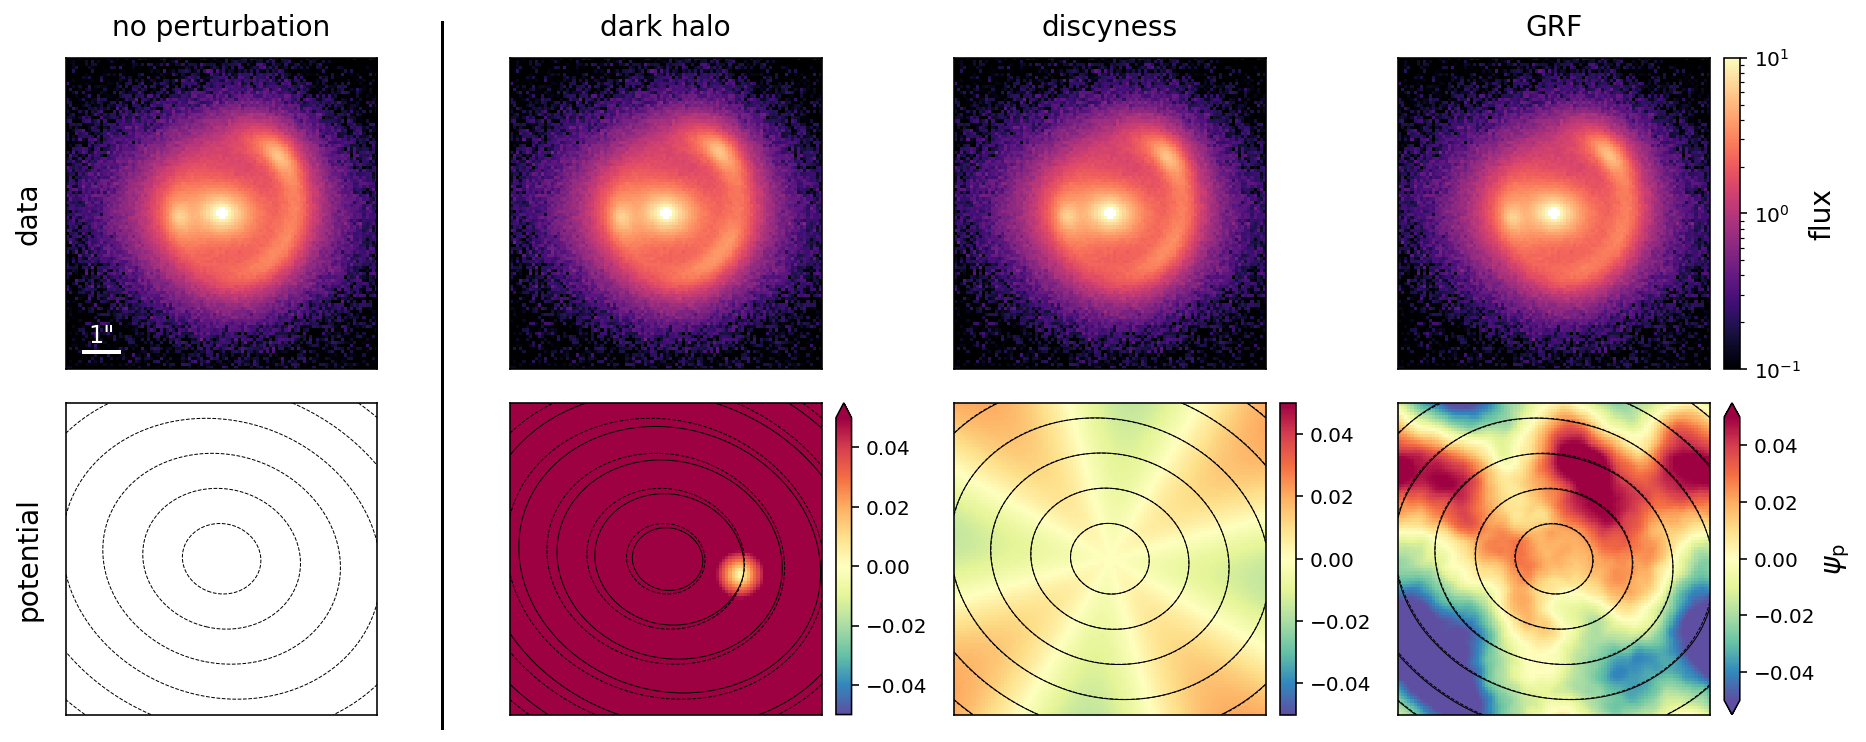

In [6]:
fontsize = 14
source_zoom_in = True

norm_flux = LogNorm(1e-1, 1e1)
vmax_pot= 0.05
norm_pot = Normalize(-vmax_pot, vmax_pot)

cb_pad = 0.1

num_rows = 2
num_cols = 1+len(perturb_types)
fig, axes = plt.subplots(num_rows, num_cols,
                         #gridspec_kw={'width_ratios':[0.6]+[1]*num_cols},
                         figsize=(15, 6.2))

# remove all ticks from axes
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, perturb_type in enumerate(perturb_types):
    
    ###################
    
    # load all necessary data
    data, full_lens_image, full_kwargs_result, input_kwargs_result, \
        _, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, _ \
        = full_model_data[perturb_type]
    _, smooth_lens_image, smooth_kwargs_result, = smooth_model_data[perturb_type]
    _, pixsrc_lens_image, pixsrc_kwargs_result, = pixsrc_model_data[perturb_type]
    
    extent = full_lens_image.Grid.extent
    pixel_size = full_lens_image.Grid.pixel_width
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates
    x_grid_fit, y_grid_fit = full_lens_image.Grid.model_pixel_coordinates('lens')
    
    # create a grid for zooming in on potential perturbation
    #full_lens_image.Grid.create_model_grid(grid_center=src_center,
    #                                       grid_shape=(2.8, 2.8),
    #                                       pixel_scale_factor=0.33,
    #                                       name='potential_plot', overwrite=True)
    
    # shift input potential perturbation such that minimum value is 0
    perturb_input_plot = perturb_input # - perturb_input.min()
    
    full_potential_no_pert = full_lens_image.LensModel.potential(x_grid, y_grid, 
                                                                 input_kwargs_result['kwargs_lens'], 
                                                                 k=[True, True, False])
    full_potential = full_potential_no_pert + perturb_input
 
    ###################
    
    # misc
    last_col = (i == len(perturb_types)-1)
    
    # first column
    if i == 0:
        # 0.1) data without perturbations
        ax = axes[0, 0]
        set_column_title(ax, "no perturbation", fontsize=fontsize)
        im = ax.imshow(data_no_pert, extent=extent, norm=norm_flux, cmap=cmap_flux)
        im.set_rasterized(True)
        nice_colorbar(im, pad=cb_pad,  label=None, 
                      colorbar_kwargs={'shrink': 0.8},
                      fontsize=fontsize, invisible=not last_col)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='white', fontsize=fontsize-2)
        #add_text_box(ax, "data", fontsize=fontsize, txt_color='white', bg_color='black')
        ax.text(-0.12, 0.5 , "data", fontsize=fontsize, rotation=90, ha='center', va='center',
                transform=ax.transAxes)

        # 0.2) full potential
        ax = axes[1, 0]
        im = ax.imshow(np.zeros_like(perturb_input), extent=extent, norm=None, cmap='gray_r', alpha=1)
        #im.set_rasterized(True)
        ax.contour(full_potential_no_pert, extent=extent, colors='black', linestyles='--', linewidths=0.5, alpha=1)
        nice_colorbar(im, pad=cb_pad, label=None, 
                      colorbar_kwargs={'shrink': 0.8},
                      fontsize=fontsize, invisible=True)
        #add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
        #              color='black', fontsize=fontsize-2)
        #add_text_box(ax, "potential", fontsize=fontsize, txt_color='black', bg_color='white')
        ax.text(-0.12, 0.5 , "potential", fontsize=fontsize, rotation=90, ha='center', va='center',
                transform=ax.transAxes)
    
    
    # remaining columns
    
    # 0.1) data without perturbations
    ax = axes[0, i+1]
    set_column_title(ax, f"{perturb_type}", fontsize=fontsize)
    im = ax.imshow(data, extent=extent, norm=norm_flux, cmap=cmap_flux)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad,  label=r"flux", 
                  colorbar_kwargs={'shrink': 0.8},
                  fontsize=fontsize, invisible=not last_col)

    # 0.2) full potential
    ax = axes[1, i+1]
    im = ax.imshow(perturb_input_plot, extent=extent, norm=norm_pot, cmap=cmap_corr)
    im.set_rasterized(True)
    ax.contour(full_potential_no_pert, extent=extent, colors='black', linestyles='--', linewidths=0.5, alpha=1)
    ax.contour(full_potential, extent=extent, colors='black', linestyles='-', linewidths=0.5, alpha=1)
    label = r"$\psi_{\rm p}$" if last_col else None
    cb = nice_colorbar_residuals(im, perturb_input_plot, pad=cb_pad, label=label, 
                            vmin=norm_pot.vmin, vmax=norm_pot.vmax,
                            colorbar_kwargs={'shrink': 0.8},
                            fontsize=fontsize, invisible=False)
    #if not last_col:
    #    cb.set_ticks([])
        
        
line = plt.Line2D([0.299, 0.299], [0.12, 0.91], transform=fig.transFigure, color="black")
fig.add_artist(line)
    
fig.subplots_adjust(hspace=0.05, wspace=0.3)
plt.show()


In [7]:
if SAVE_FIGURES:
    figure_name = 'data_summary.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')